In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
#import osmnx as ox
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
import random

import warnings
warnings.filterwarnings('ignore')

# Chemins d'accès aux données
repDataConsolidees = '../../dataConsolidees.gouv/'

# Liste des fichiers usagers disponibles
!pwd
!ls {repDataConsolidees}*  -lrt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


/Users/stephane/Documents/Professionnel/Formation/Certificats/Datascientest/4 - Projet AccidentsRoutiers/scripts/1 - ExplorationDonnees
ls: -lrt: No such file or directory
../../dataConsolidees.gouv/agg_accidents.csv
../../dataConsolidees.gouv/agg_usagers.csv
../../dataConsolidees.gouv/test_set.csv
../../dataConsolidees.gouv/test_stat.csv
../../dataConsolidees.gouv/train_set.csv
../../dataConsolidees.gouv/usagers.csv


## ETAPE 1 - CHARGEMENT ET VERIFICATION DES DONNEES

#### Chargement des données dans un df
1. Sélection des données éligibles (dépendant de la qualité du jeu de données identifié lors des étapes de consolidation
   Nous pouvons retenir les données de 2019 à 2022

2. Prévisualisation des données  (macro approche)
3. Découpage des données en deux ensembles train/test avant de démarrer la phase d'exploration des données uniquement sur train
   Test ne sera utilisé qu'à la fin de la phase d'entraintement du modèle

   ==> Une fois terminée, nous pourrons lancer la phase d'exploration des données sur TRAIN


In [2]:
# ETAPE 1 - Chgt des données 
annee_min = 2020
df = pd.read_csv (repDataConsolidees + "agg_usagers.csv", dtype={'user_actp' : str}, ) # index_col=['id_accident', 'id_vehicule', 'num_veh', 'id_usager'])
df = df[(df.carac_an>=annee_min)]


In [3]:
# ETAPE 1 - Ctrl chgt
#df.info()

In [4]:
# ETAPE 1 - Chargement des données - Suppression des données inutiles pour notre étude
# Données texte difficilement exploitable d'autant que majoritairement en lien avec l'emplacement et nous avons les coordonnées gps.
if 'vehi_occutc' in df.columns :
    drop_col = ['id_usager', 'carac_gps', 'carac_adr', 'lieu_pr', 'lieu_pr1', 'lieu_v1', 'lieu_v2', 'lieu_voie', 'lieu_env1',
               # Ces variables ne peuvent être utilisées dans un modèle de prédiction car obtenues à partir de la variable cible
                'agg_nb_total_indemne', 'agg_nb_total_blesse_leger', 'agg_nb_total_blesse_grave', 'agg_nb_total_tue'
               ]
    df = df.drop(drop_col, axis = 1)



## ETAPE 2 - EXPLORATION DES DONNEES - ANALYSE GLOBALE DU DF

In [5]:
# ETAPE 2 - Exploration des données - Analyse Globale du df

print (df.shape)                         # Vérification dimensions (nb lignes / colonnes disponibles)
display(df.info())                       # Vérification des types de chaque colonne pour MaJ si nécessaire
display(df.describe(include = "all"))    # Contrôle distribution / cohérence des valeurs de chaque colonne (numériques/catégoriques)

(361205, 68)
<class 'pandas.core.frame.DataFrame'>
Index: 361205 entries, 2275150 to 2636354
Data columns (total 68 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id_accident                   361205 non-null  int64  
 1   id_vehicule                   361205 non-null  int64  
 2   num_veh                       361205 non-null  object 
 3   carac_an                      361205 non-null  int64  
 4   carac_mois                    361205 non-null  int64  
 5   carac_jour                    361205 non-null  int64  
 6   carac_hrmn                    361205 non-null  int64  
 7   carac_agg                     361205 non-null  int64  
 8   carac_atm                     361205 non-null  int64  
 9   carac_col                     361205 non-null  int64  
 10  carac_com                     361205 non-null  float64
 11  carac_dept                    361205 non-null  int64  
 12  carac_gps_lat                

None

,id_accident,id_vehicule,num_veh,carac_an,carac_mois,carac_jour,carac_hrmn,carac_agg,carac_atm,carac_col,carac_com,carac_dept,carac_gps_lat,carac_gps_long,carac_int,carac_lum,lieu_catr,lieu_circ,lieu_infra,lieu_larrout,lieu_lartpc,lieu_nbv,lieu_plan,lieu_prof,lieu_situ,lieu_surf,lieu_vma,lieu_vosp,vehi_catv,vehi_choc,vehi_manv,vehi_motor,vehi_obs,vehi_obsm,vehi_occutc,vehi_senc,user_an_nais,user_catu,user_actp,user_etatp,user_locp,user_place,user_secu1,user_secu2,user_secu3,user_sexe,user_trajet,user_gravite,agg_catv_perso,agg_is_conducteur_vehicule,agg_is_conductrice_vehicule,agg_nb_pieton_vehicule,agg_nb_passager_vehicule,agg_nb_indemne_vehicule,agg_nb_blesse_leger_vehicule,agg_nb_blesse_grave_vehicule,agg_nb_tue_vehicule,agg_nb_total_vehicule,agg_nb_total_velo,agg_nb_total_vsp,agg_nb_total_moto,agg_nb_total_vl,agg_nb_total_pl,agg_nb_total_va,agg_nb_total_conducteur,agg_nb_total_conductrice,agg_nb_total_pieton,agg_nb_total_passager
count,3.612050e+05,3.612050e+05,361205,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,355264.000000,361205.000000,361205,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000,361205.000000
unique,NaN,NaN,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,A01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,217407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.021059e+11,4.541907e+07,NaN,2021.059155,6.744029,15.670699,1388.635420,1.620764,1.604510,3.710998,204.163929,110.556642,44.229745,2.494675,2.061134,1.893656,3.297632,1.831971,0.786985,-0.577322,0.003028,2.448036,1.289805,1.232613,1.514763,1.255187,60.455675,0.204881,12.631561,2.867294,7.068150,1.232962,1.126729,1.582481,0.066419,1.560203,1982.770838,1.328514,NaN,0.093711,0.240730,2.073410,1.859393,0.997827,-0.916696,1.277679,2.950111,0.782904,3.669105,0.742844,0.253546,0.167703,0.567498,0.750142,0.690796,0.247970,0.042682,1.898465,0.089395,0.181468,0.146753,1.347116,0.078296,0.055437,1.411201,0.482216,0.172362,0.819587
std,7.991879e+07,7.009859e+07,NaN,0.799173,3.352410,8.752680,542.364948,0.485198,1.676352,1.909490,177.862388,212.851187,12.442056,19.926934,1.990611,1.471891,1.291582,0.903570,2.146983,1.875222,0.197594,1.403622,0.668548,0.545609,1.473697,0.809010,25.750183,0.663555,13.407412,2.397861,8.047683,1.019489,3.257119,1.228942,1.135490,0.814595,18.836366,0.609835,NaN,0.367365,0.993582,2.569461,2.262643,3.058030,0.884677,0.544994,3.087776,0.797181,0.989460,0.437067,0.435041,0.459029,1.466564,1.242018,0.936888,0.534343,0.225817,0.853743,0.338671,0.402524,0.371755,0.959820,0.308823,0.235720,0.876922,0.650120,0.471057,1.740414
min,2.020000e+11,

In [6]:
# 1 Nombre d'accidents distincts
#df.index.get_level_values('id_accident').nunique()        # si id_accident est dans l'index
df.id_accident.nunique()                                   # sinon


159564

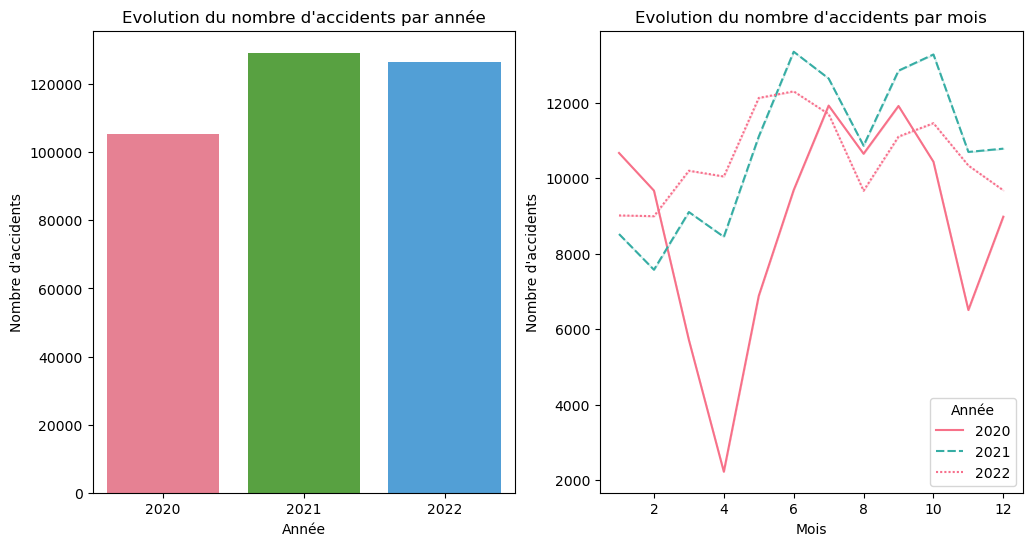

In [7]:
# ETAPE 2 - Vérification visuelle --> Distribution des accidents par années / mois
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
df['count'] = 1                                               # ajouté pour compter le nb d'accidents par mois/année

# Définir les couleurs pour chaque année
#couleurs = {2018: 'blue', 2019: 'orange', 2007: 'green'}

sns.countplot (x = df.carac_an, palette='husl', ax=axes[0])
axes[0].set_title("Evolution du nombre d'accidents par année")
axes[0].set_xlabel('Année')
axes[0].set_ylabel("Nombre d'accidents")

sns.lineplot(x='carac_mois', y='count',  hue='carac_an', style='carac_an',  estimator='sum', palette='husl', data=df, ax=axes[1])
axes[1].set_title("Evolution du nombre d'accidents par mois")
axes[1].set_xlabel('Mois')
axes[1].set_ylabel("Nombre d'accidents")

axes[1].legend(title='Année', bbox_to_anchor=(1, 0), loc='lower right')

# Décrochage Avril et novembre 2020 --> confinement 
df = df.drop(['count'], axis=1)                             # Suppression de la colonne 

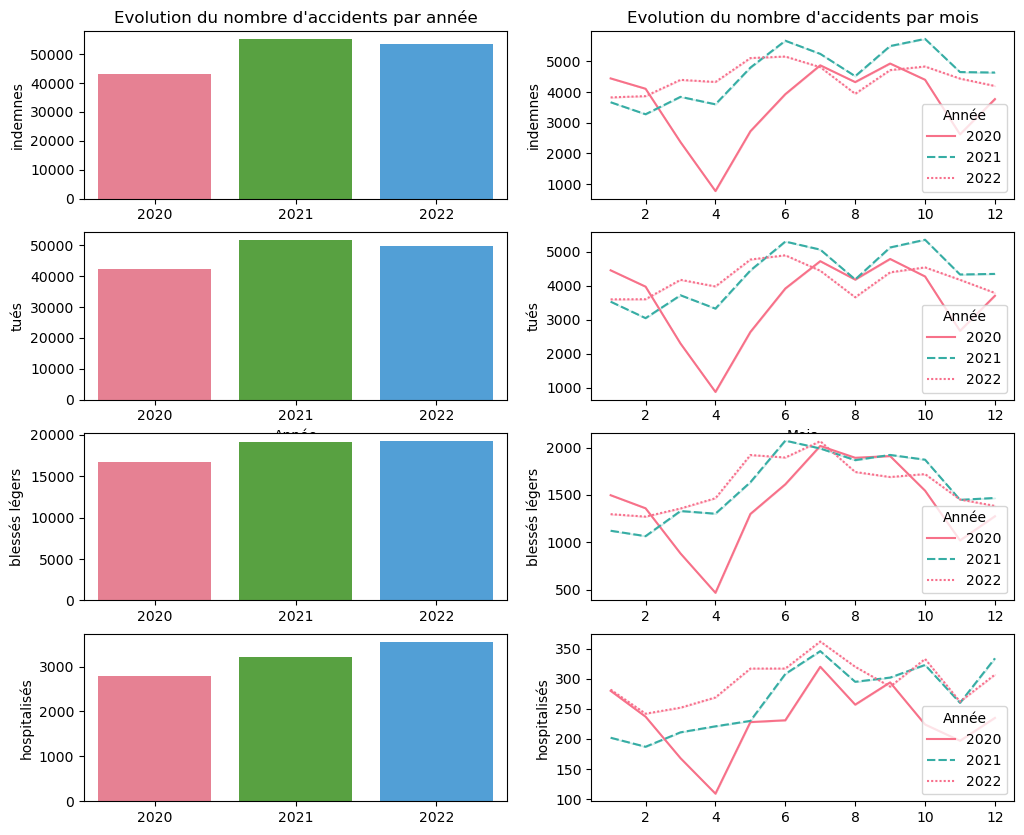

In [8]:
# ETAPE 2 - Vérification visuelle --> Distribution des accidents mortels par années / mois
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10))
df['count'] = 1                                               # ajouté pour compter le nb d'accidents par mois/année

# Définir les couleurs pour chaque année
#couleurs = {2018: 'blue', 2019: 'orange', 2007: 'green'}
for i in range (0, 4) :
    sns.countplot (x = df.loc[(df.user_gravite == i), 'carac_an'], palette='husl', ax=axes[i,0])
    sns.lineplot(x='carac_mois', y='count',  hue='carac_an', style='carac_an',  estimator='sum', palette='husl', data=df[(df.user_gravite == i)], ax=axes[i, 1])
    
    if i==0 :
        axes[i, 0].set_title("Evolution du nombre d'accidents par année")
        axes[i, 1].set_title("Evolution du nombre d'accidents par mois")
        axes[i, 0].set_xlabel('')
        axes[i, 1].set_xlabel('')
        ordonnee = 'indemnes'
        
    elif i == 2 :
        ordonnee = 'blessés légers'
        axes[i, 0].set_xlabel('')
        axes[i, 1].set_xlabel('')
        
    elif i == 3 :
        ordonnee = 'hospitalisés'
        axes[i, 0].set_xlabel('')
        axes[i, 1].set_xlabel('')
        
    else :
        ordonnee = 'tués'
        axes[i, 0].set_xlabel('Année')        
        axes[i, 1].set_xlabel('Mois')
        
    axes[i, 0].set_ylabel(ordonnee)
    axes[i, 1].set_ylabel(ordonnee)
    axes[i, 1].legend(title='Année', bbox_to_anchor=(1, 0), loc='lower right')

# ===>>> Constat de l'augmentation de l'agravation des accidents en (décembre) 2022

df = df.drop(['count'], axis=1)                             # Suppression de la colonne count 

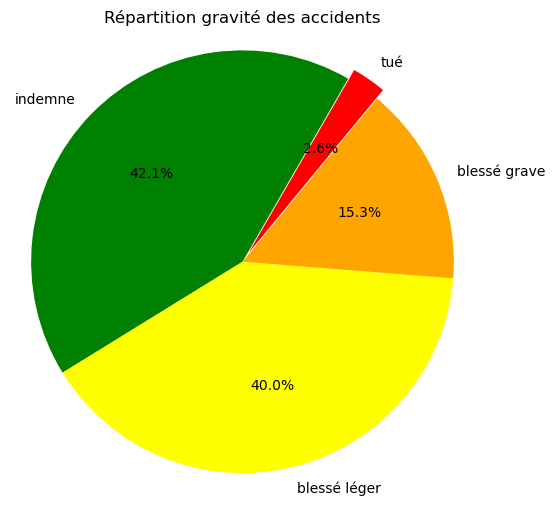

In [9]:
# Camembert variable cible par année disponible
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

# Suppression des usagers sans gravité --> il s'agit des personnes en délit de fuite
gravite = df[(df.user_gravite != -1)]['user_gravite'].value_counts().sort_index()
cols_to_labels = ['indemne', 'blessé léger', 'blessé grave', 'tué']
explode = [0, 0, 0, 0.05]
plt.pie(gravite,  
                labels=cols_to_labels,
                 explode=explode,
                 autopct='%1.1f%%', startangle=60,
                 colors=['green', 'yellow', 'orange', 'red']
               )
# Titre du camembert
plt.title(f"Répartition gravité des accidents")

# Affichage du camembert
plt.axis('equal')  # Assure que le camembert est bien circulaire
plt.show()



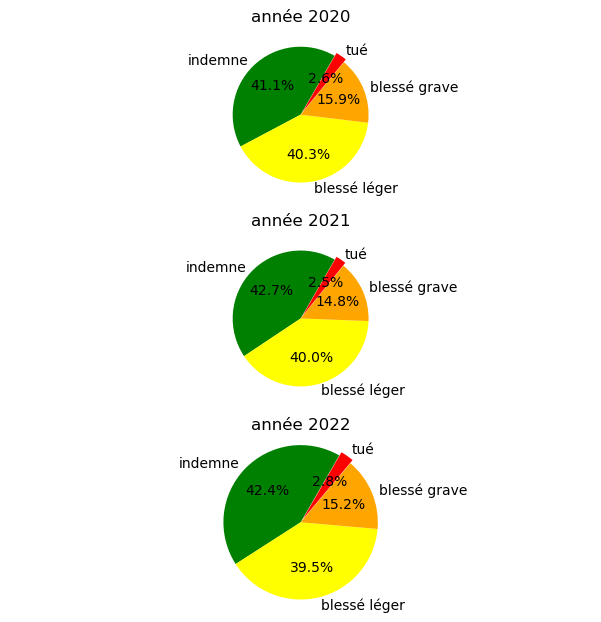

In [10]:
# Camembert variable cible par année disponible
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7.5, 7.5))

annees = sorted(df.carac_an.unique()) 
for index, annee in enumerate (annees) :
    # Suppression des usagers sans gravité --> il s'agit des personnes en délit de fuite
    gravite = df[(df.user_gravite != -1) & (df.carac_an == annee)]['user_gravite'].value_counts().sort_index()
    cols_to_labels = ['indemne', 'blessé léger', 'blessé grave', 'tué']
    explode = [0, 0, 0, 0.05]
    axes[index].pie(gravite,  
        labels=cols_to_labels,
        explode=explode,
        autopct='%1.1f%%', startangle=60,
        colors=['green', 'yellow', 'orange', 'red']
    )
    # Titre du camembert
    axes[index].set_title(f"année {annee}")

    

    # Affichage du camembert
plt.axis('equal')  # Assure que le camembert est bien circulaire
plt.show()



Text(0.5, 0, 'Départements')

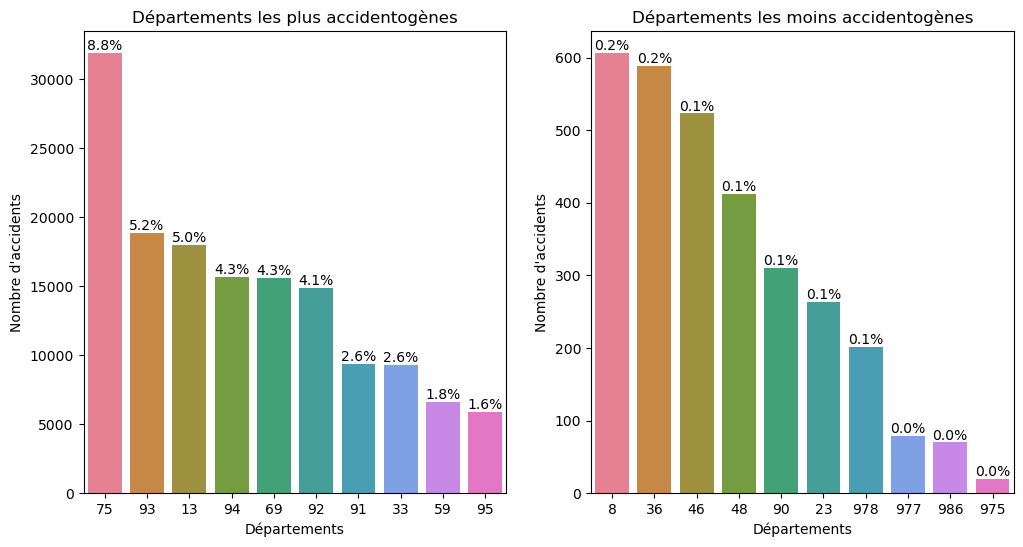

In [39]:
# Analyse par départements
# ETAPE 2 - Vérification visuelle --> Distribution des accidents par années / mois
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
df['count'] = 1                                               # ajouté pour compter le nb d'accidents par mois/année

# Définir les couleurs pour chaque année
# A Gauche : les 10 départements les plus accidentogènes
nbAccidents = df.carac_dept.value_counts().head(10)
sns.barplot (x=nbAccidents.index, y=nbAccidents,  order=nbAccidents.index, palette='husl', ax=axes[0])

# Pourcentages
total = df['count'].sum()
for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{(height / total * 100):.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

axes[0].set_title("Départements les plus accidentogènes")
axes[0].set_ylabel("Nombre d'accidents")
axes[0].set_xlabel("Départements")

# A droite les 10 les moins accidentogènes
nbAccidents = df.carac_dept.value_counts().tail(10)
sns.barplot (x=nbAccidents.index, y=nbAccidents,  order=nbAccidents.index, palette='husl', ax=axes[1])

# Pourcentages
for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{(height / total * 100):.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

axes[1].set_title("Départements les moins accidentogènes")
axes[1].set_ylabel("Nombre d'accidents")
axes[1].set_xlabel("Départements")

Text(0.5, 0, 'Départements')

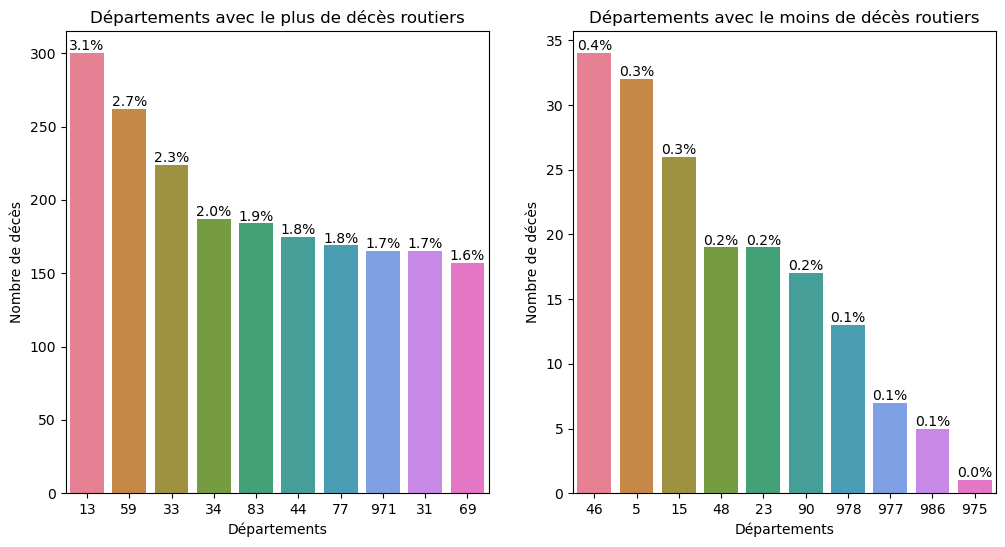

In [44]:
# Analyse par départements des accidents mortels
# ETAPE 2 - Vérification visuelle --> Distribution des accidents par années / mois
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
df['count'] = 1                                               # ajouté pour compter le nb d'accidents par mois/année

# Définir les couleurs pour chaque année
# A Gauche : les 10 départements les plus accidentogènes
nbAccidents = df[(df.user_gravite==3)]['carac_dept'].value_counts().head(10)
sns.barplot (x=nbAccidents.index, y=nbAccidents,  order=nbAccidents.index, palette='husl', ax=axes[0])

# Pourcentages
total = df[df.user_gravite==3]['count'].sum()
for p in axes[0].patches:
    height = p.get_height()
    axes[0].annotate(f'{(height / total * 100):.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

axes[0].set_title("Départements avec le plus de décès routiers")
axes[0].set_ylabel("Nombre de décès")
axes[0].set_xlabel("Départements")

# A droite les 10 les moins accidentogènes
nbAccidents = df[(df.user_gravite==3)]['carac_dept'].value_counts().tail(10)
sns.barplot (x=nbAccidents.index, y=nbAccidents,  order=nbAccidents.index, palette='husl', ax=axes[1])

# Pourcentages
for p in axes[1].patches:
    height = p.get_height()
    axes[1].annotate(f'{(height / total * 100):.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

axes[1].set_title("Départements avec le moins de décès routiers")
axes[1].set_ylabel("Nombre de décès")
axes[1].set_xlabel("Départements")

In [58]:
df.carac_hrmn.value_counts()

carac_hrmn
1800    4963
1700    4475
1730    4045
1830    3990
1900    3863
1630    3807
1600    3714
1500    3303
1530    3026
1400    3014
1930    2984
2000    2812
1745    2796
1715    2777
1430    2750
1815    2719
1750    2701
900     2655
800     2642
830     2633
1645    2533
1845    2506
1100    2499
1200    2496
1300    2454
1740    2435
1720    2423
1820    2380
1230    2359
1130    2350
1000    2346
1330    2342
1615    2254
1915    2148
930     2136
1650    2112
1030    2080
730     2058
1810    2057
1850    2043
1710    2028
1640    1989
2030    1981
1545    1971
2100    1958
1840    1936
1620    1917
1945    1907
1550    1794
1520    1782
1515    1781
1445    1773
1215    1760
1910    1695
1540    1668
745     1663
1920    1652
845     1642
1610    1639
1415    1618
750     1615
850     1594
1450    1569
1950    1565
1350    1565
1145    1553
1220    1549
1345    1541
815     1518
1115    1492
700     1488
1315    1487
1510    1483
1420    1473
1725    1459
1210    1449
1

Text(0.5, 0, 'Tranches horaires')

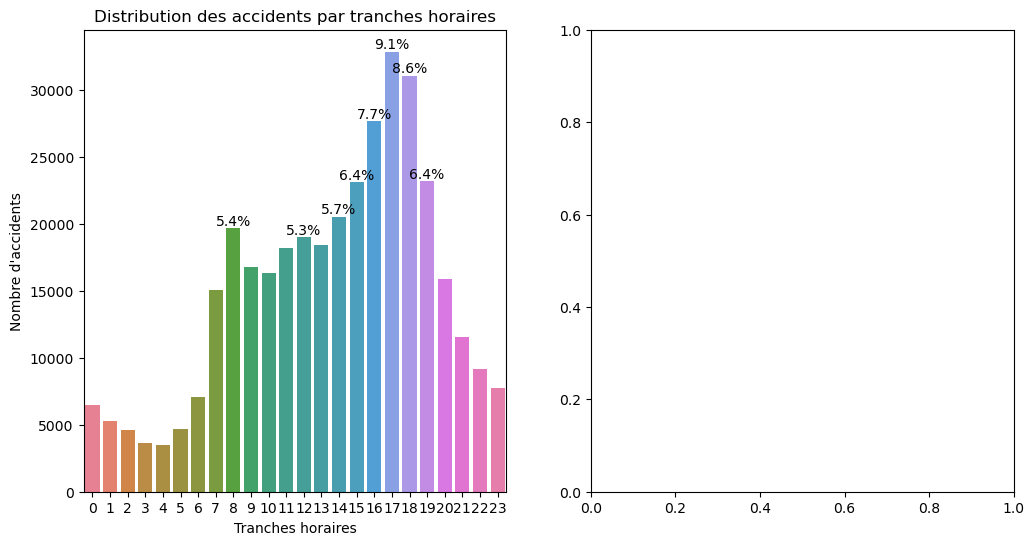

In [66]:
# Répartition des accidents mortels par créneaux horaires

# Conversion du champ 'hrmn' en format datetime
df['date'] = pd.to_datetime(df['carac_hrmn'].astype(str).str.zfill(4), format='%H%M')
df['heure'] = df['date'].dt.hour
hourly_counts = df.groupby('heure').size().reset_index(name='counts')

# Analyse par départements des accidents mortels
# ETAPE 2 - Vérification visuelle --> Distribution des accidents par années / mois
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
df['count'] = 1                                               # ajouté pour compter le nb d'accidents par mois/année

# Définir les couleurs pour chaque année
# A Gauche : les 10 départements les plus accidentogènes
sns.barplot (x='heure', y='counts',  data=hourly_counts, palette='husl', ax=axes[0])

# Pourcentages
#total = df[df.user_gravite==3]['count'].sum()
total = df['count'].sum()
for p in axes[0].patches:
    height = p.get_height()
    percent=(height / total * 100)
    if percent> 5.2 :
        axes[0].annotate(f'{percent:.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

axes[0].set_title("Distribution des accidents par tranches horaires")
axes[0].set_ylabel("Nombre d'accidents")
axes[0].set_xlabel("Tranches horaires")




Text(0.5, 0, 'Tranches horaires')

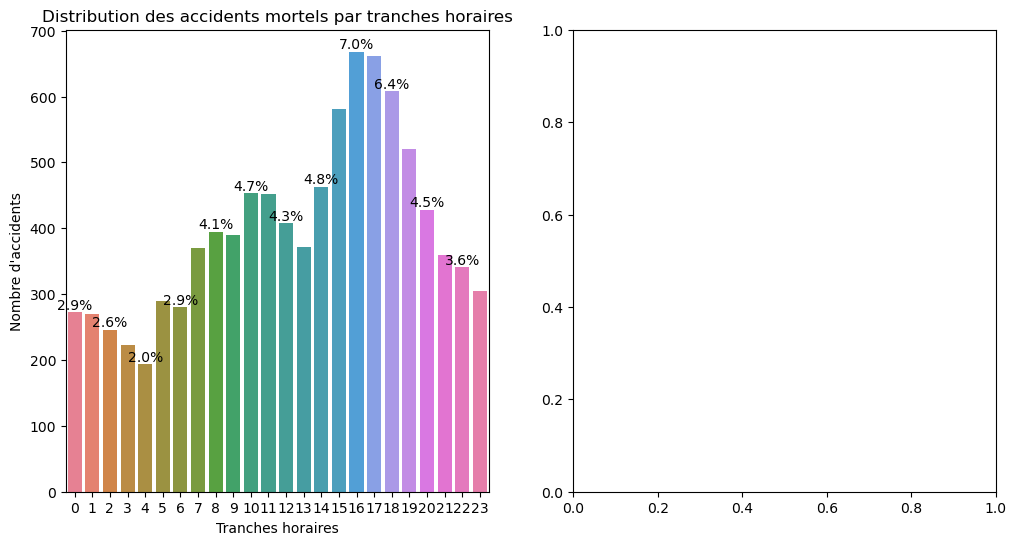

In [70]:

hourly_counts = df[(df.user_gravite==3)].groupby('heure').size().reset_index(name='counts')

# Analyse par départements des accidents mortels
# ETAPE 2 - Vérification visuelle --> Distribution des accidents par années / mois
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
df['count'] = 1                                               # ajouté pour compter le nb d'accidents par mois/année

# Définir les couleurs pour chaque année
# A Gauche : les 10 départements les plus accidentogènes
sns.barplot (x='heure', y='counts',  data=hourly_counts, palette='husl', ax=axes[0])

# Pourcentages
total = df[df.user_gravite==3]['count'].sum()
compteur=0
for p in axes[0].patches:
    height = p.get_height()
    percent=(height / total * 100)
    compteur = (compteur+1)% 2
    if compteur == 1 :
        axes[0].annotate(f'{percent:.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

axes[0].set_title("Distribution des accidents mortels par tranches horaires")
axes[0].set_ylabel("Nombre d'accidents")
axes[0].set_xlabel("Tranches horaires")

## ETAPE 3 - GEOLOCALISATION DES ACCIDENTS 

<Axes: title={'center': 'Données géolocalisées pour la période 2020-2022'}>

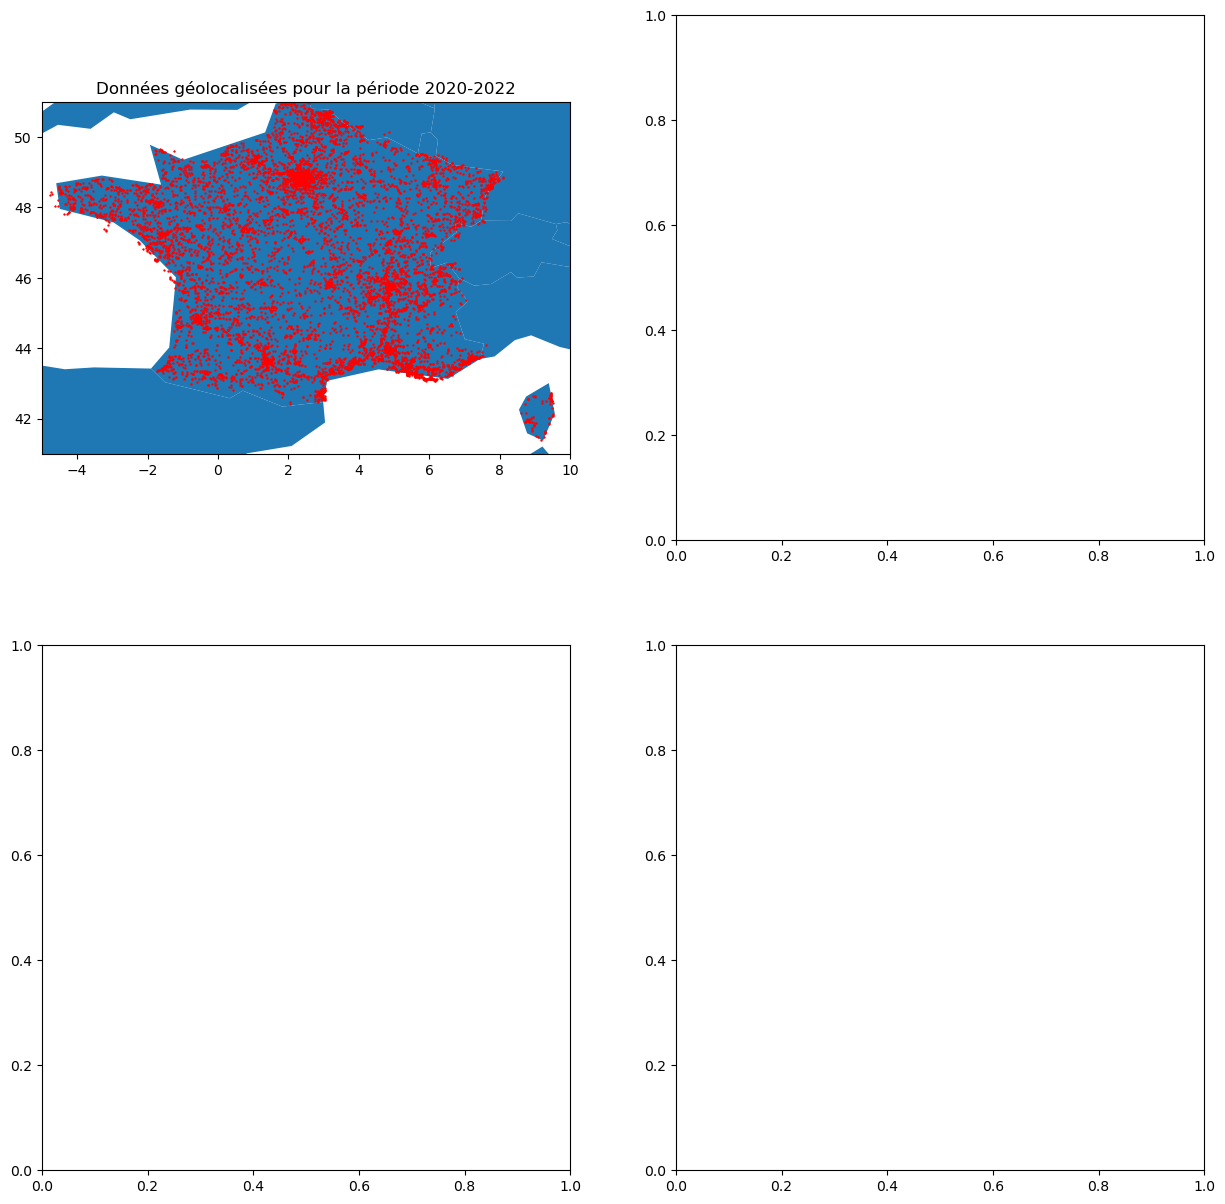

In [48]:
nb_graphes=2
# Charger les contours des pays
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_tue = df.loc[(df.user_gravite == 3), ['carac_an', 'carac_gps_long', 'carac_gps_lat']]

# Créer une figure et des axes pour les sous-graphes
fig, axs = plt.subplots(nb_graphes, 2, figsize=(15, 15))

# Préparation des cartes par année
row_idx = 0
col_idx = 0
    
# Tracer le graphe sur le sous-axe correspondant
ax = axs[row_idx, col_idx]
    
# zoom sur une région du monde : France métropolitaine
world.plot(ax=ax)                               # Ajouter les contours de pays
ax.set_xlim(-5, 10)                             # Longitude
ax.set_ylim(41, 51)                             # Latitude
ax.set_title(f'Données géolocalisées pour la période 2020-2022')

# Visualisation géographique des accidents
points = [Point(xy) for xy in zip(df_tue['carac_gps_long'], df_tue['carac_gps_lat'])]
gdf = gpd.GeoDataFrame(geometry=points, columns=['geometry'])
gdf.plot(ax=ax, color='red', markersize=0.5)      # Ajouter les points sur la carte



i= 0 annee= 2020 ax_ligne= 0 ax_colonne= 0
i= 1 annee= 2021 ax_ligne= 1 ax_colonne= 0
i= 2 annee= 2022 ax_ligne= 2 ax_colonne= 0


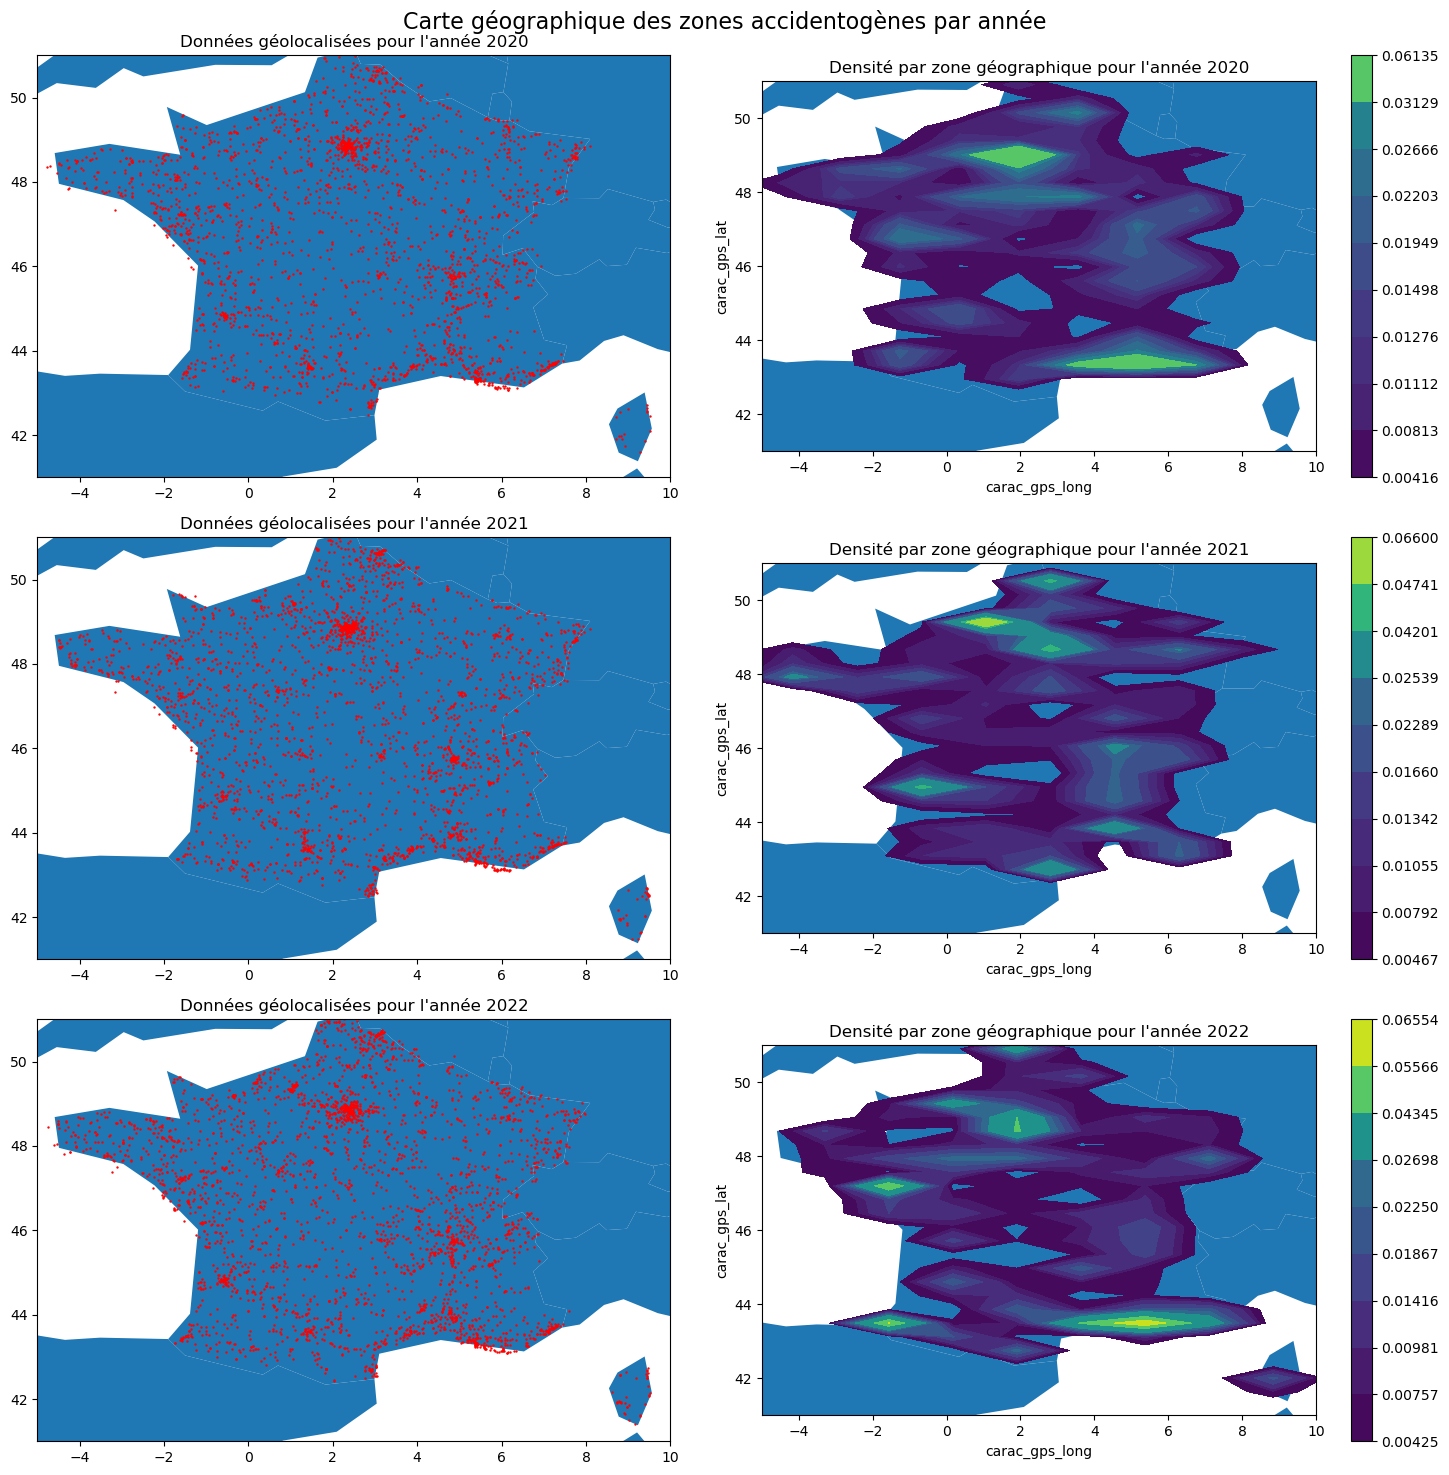

In [11]:
#df.reset_index(inplace=True)
nb_annees = df['carac_an'].unique() 
nb_graphes = len(nb_annees)
nb_rows = nb_graphes // 2 + nb_graphes % 2               # Nombre de lignes à afficher (2 graphes par lignes

# Charger les contours des pays
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_tue = df.loc[(df.user_gravite == 3), ['carac_an', 'carac_gps_long', 'carac_gps_lat']]

# Créer une figure et des axes pour les sous-graphes
fig, axs = plt.subplots(nb_graphes, 2, figsize=(15, 15))

# Préparation des cartes par année
for i, annee in enumerate(nb_annees):
    row_idx = i 
    col_idx = 0
    print ("i=", i, "annee=", annee, "ax_ligne=", row_idx, "ax_colonne=", col_idx)
    
    # Tracer le graphe sur le sous-axe correspondant
    ax = axs[row_idx, col_idx]
    
    # zoom sur une région du monde : France métropolitaine
    world.plot(ax=ax)                               # Ajouter les contours de pays
    ax.set_xlim(-5, 10)                             # Longitude
    ax.set_ylim(41, 51)                             # Latitude
    ax.set_title(f'Données géolocalisées pour l\'année {annee}')

    # Visualisation géographique des accidents
    points = [Point(xy) for xy in zip(df_tue.loc[(df.carac_an == annee), 'carac_gps_long'], df_tue.loc[(df.carac_an == annee), 'carac_gps_lat'])]
    gdf = gpd.GeoDataFrame(geometry=points, columns=['geometry'])
    gdf.plot(ax=ax, color='red', markersize=0.5)      # Ajouter les points sur la carte

    # Tracer le graphe sur le sous-axe correspondant
    col_idx = col_idx + 1
    ax = axs[row_idx, col_idx]
    
    # zoom sur une région du monde : France métropolitaine
    world.plot(ax=ax)                               # Ajouter les contours de pays
    ax.set_xlim(-5, 10)                             # Longitude
    ax.set_ylim(41, 51)                             # Latitude
    ax.set_title(f'Densité par zone géographique pour l\'année {annee}')
    sns.kdeplot(x=df_tue.loc[(df.carac_an == annee), 'carac_gps_long'], y=df_tue.loc[(df.carac_an == annee), 'carac_gps_lat'], cmap='viridis', shade=True, ax=ax, bw=0.05, cbar=True, bw_adjust=0.1)
    #sns.jointplot(data=df_tue.loc[(df['carac_an'] == annee), ['gps_long', 'gps_lat']], x='gps_long', y='gps_lat', kind='kde', cmap='viridis', ax=ax, bw = 0.3, cbar=True)

# Supprimer les sous-graphes non utilisés
#for i in range(nb_graphes, nb_rows * 2):
#    ax = axs.flatten()[i]
#    ax.remove()
    
plt.suptitle("Carte géographique des zones accidentogènes par année", fontsize=16)

# Ajuster l'espacement entre les sous-graphes
plt.tight_layout()

# Afficher la figure
plt.show()



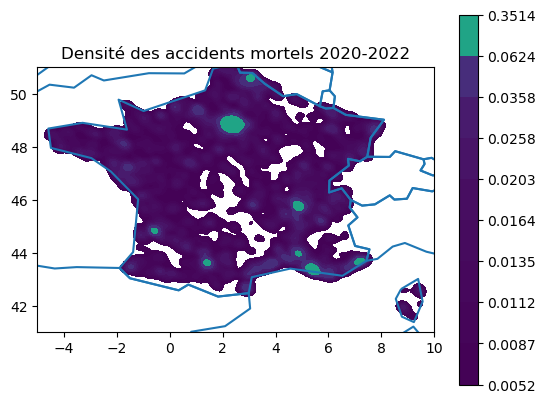

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
df_tue = df.loc[(df.user_gravite ==3) &(df.carac_gps_long>-5) & (df.carac_gps_long<10) & (df.carac_gps_lat>41) & (df.carac_gps_long<51), ['carac_gps_long', 'carac_gps_lat']]

# Charger les données géographiques des pays
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Ajouter les contours des pays
ax = world.boundary.plot()
# Tracer le graphe de densité des points géographiques
sns.kdeplot(x=df_tue['carac_gps_long'], y=df_tue['carac_gps_lat'], cmap='viridis', shade=True, ax=ax, bw=0.5, bw_adjust=0.1, cbar=True)
ax.set_xlim(-5, 10)                             # Longitude
ax.set_ylim(41, 51)                             # Latitude

# Ajouter un titre au graphe
plt.title('Densité des accidents mortels 2020-2022')
ax.set_ylabel("")
ax.set_xlabel("")
# Afficher le graphe
plt.show()


## ETAPE 4 - DECOUPAGE DU DF EN DEUX ENSEMBLES TRAIN / TEST


1. Suppression des enregistrements variable cible en NaN (=-1 dans notre df) : il s'agit des personnes en fuite
2. Découpage de notre ensemble de données en train / test


In [74]:
# 1. Découpage des données en deux ensembles train/test de manière aléatoire tout en maintenant toutes les
#    lignes d'un même accident dans un même ensemble.

# Récupération des id_accident unique
id_accident_unique = df.id_accident.unique()

# Mélanger la liste avec un random_state fixe
#random_state = 42     
#random.seed(random_state)
#id_accident_melange = random.sample(id_accident_unique, len(ma_liste))

# Diviser les id_accident en ensembles d'entraînement et de test
id_accident_train, id_accident_test = train_test_split(id_accident_unique, test_size=0.25, random_state=42)
train = df[df['id_accident'].isin(id_accident_train)]
test = df[df['id_accident'].isin(id_accident_test)]

# Résultat obtenu
print("Taille de l'ensemble d'entraînement :", len(train))
print("Taille de l'ensemble de test :", len(test))

# Sauvegarde des ensembles 
test.to_csv(repDataConsolidees + "test_set.csv", index=False)
train.to_csv(repDataConsolidees + "train_set.csv", index=False)


Taille de l'ensemble d'entraînement : 270932
Taille de l'ensemble de test : 90273


In [75]:
# Controle
train.head()

,id_accident,id_vehicule,num_veh,carac_an,carac_mois,carac_jour,carac_hrmn,carac_agg,carac_atm,carac_col,carac_com,carac_dept,carac_gps_lat,carac_gps_long,carac_int,carac_lum,lieu_catr,lieu_circ,lieu_infra,lieu_larrout,lieu_lartpc,lieu_nbv,lieu_plan,lieu_prof,lieu_situ,lieu_surf,lieu_vma,lieu_vosp,vehi_catv,vehi_choc,vehi_manv,vehi_motor,vehi_obs,vehi_obsm,vehi_occutc,vehi_senc,user_an_nais,user_catu,user_actp,user_etatp,user_locp,user_place,user_secu1,user_secu2,user_secu3,user_sexe,user_trajet,user_gravite,agg_catv_perso,agg_is_conducteur_vehicule,agg_is_conductrice_vehicule,agg_nb_pieton_vehicule,agg_nb_passager_vehicule,agg_nb_indemne_vehicule,agg_nb_blesse_leger_vehicule,agg_nb_blesse_grave_vehicule,agg_nb_tue_vehicule,agg_nb_total_vehicule,agg_nb_total_velo,agg_nb_total_vsp,agg_nb_total_moto,agg_nb_total_vl,agg_nb_total_pl,agg_nb_total_va,agg_nb_total_conducteur,agg_nb_total_conductrice,agg_nb_total_pieton,agg_nb_total_passager
2275152,202000000002,154742273,A01,2020,3,7,835,2,7,6,657.0,91,48.69000,2.41000,9,2,4,2,0,-1.0,0.0,2,3,1,1,1,50.0,0,7,2,26,1.0,0,1,0,3.0,1997.0,1,0,0,0,1,8,0,-1,1,1,0,4,1,0,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0
2275153,202000000002,154742273,A01,2020,3,7,835,2,7,6,657.0,91,48.69000,2.41000,9,2,4,2,0,-1.0,0.0,2,3,1,1,1,50.0,0,7,2,26,1.0,0,1,0,3.0,1967.0,3,3,1,3,10,0,-1,-1,1,5,1,4,1,0,1,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1,0
2275154,202000000003,154742271,B01,2020,3,7,1330,2,1,3,174.0,91,48.61067,2.47582,2,1,4,-1,0,-1.0,0.0,2,1,1,1,1,50.0,0,7,1,1,1.0,0,2,0,1.0,1985.0,1,0,0,0,1,1,0,-1,1,-1,0,4,1,0,0,1,1,0,1,0,2,0,0,0,2,0,0,2,0,0,1
2275155,202000000003,154742271,B01,2020,3,7,1330,2,1,3,174.0,91,48.61067,2.47582,2,1,4,-1,0,-1.0,0.0,2,1,1,1,1,50.0,0,7,1,1,1.0,0,2,0,1.0,2014.0,2,0,0,0,4,8,0,-1,1,-1,2,4,1,0,0,1,1,0,1,0,2,0,0,0,2,0,0,2,0,0,1
2275156,202000000003,154742272,A01,2020,3,7,1330,2,1,3,174.0,91,48.61067,2.47582,2,1,4,-1,0,-1.0,0.0,2,1,1,1,1,50.0,0,7,8,1,0.0,0,2,0,1.0,1963.0,1,0,0,0,1,1,0,-1,1,-1,0,4,1,0,0,0,1,0,0,0,2,0,0,0,2,0,0,2,0,0,1
